In [41]:
import pandas as pd
from sklearn.cross_validation import StratifiedShuffleSplit
import numpy as np
import os

In [50]:
def group_data(df, keys):
    for key in keys:
        if 'AGE' in key:
            df[key] = pd.qcut(df[key], 2, labels=[0,1])

    labels = [ '.'.join([str(df[key].iloc[i]) for key in keys]) for i in range(len(df))]
    rows, index, count = np.unique(labels, return_index=True, return_counts=True)
    # sub_dataframe 
    df_sub = df.drop(df.index[index[count==1].tolist()], inplace=False)
    for row in rows[count==1]:
        labels.remove(row)

    return df_sub, labels

def split_data(df, keys, num_iter=3, random_state=0):
    df_sub, labels = group_data(df, keys)
    return df_sub, StratifiedShuffleSplit(labels, num_iter, test_size=0.5, random_state=random_state)

def assign_filename(df, base_directory, key_in='FILE_ID', key_out='FILENAME', postfix='_reho.nii.gz'):
    df[key_out] = [os.path.join(base_directory, '%s%s' % (file_id, postfix))
                        for file_id in df[key_in]]


In [75]:
filename = 'Phenotypic_V1_0b_preprocessed1.csv'
basedir = ''
key_filename = 'FILENAME'
key_target = 'DX_GROUP'
num_iter = 3

In [46]:
csv = pd.read_csv(filename)

In [3]:
csv.head()

,Unnamed: 0,Unnamed: 0.1,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,0,1,50002,1,50002,PITT,no_filename,1,1,16.77,...,NaN,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,fail,ERROR #24,1
1,1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
3,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1


## columns to use:
* subject
* SITE_ID
* FILE_ID
* DX_GROUP
* SEX
* AGE_AT_SCAN

In [36]:
columns = ['subject', 'SITE_ID', 'FILE_ID', 'DX_GROUP', 'SEX', 'AGE_AT_SCAN']

In [37]:
df = pd.DataFrame()
for column in columns:
    df[column] = csv[column]

In [38]:
df.head()

,subject,SITE_ID,FILE_ID,DX_GROUP,SEX,AGE_AT_SCAN
0,50002,PITT,no_filename,1,1,16.77
1,50003,PITT,Pitt_0050003,1,1,24.45
2,50004,PITT,Pitt_0050004,1,1,19.09
3,50005,PITT,Pitt_0050005,1,2,13.73
4,50006,PITT,Pitt_0050006,1,1,13.37


## add filename(s?)

In [51]:
assign_filename(df, basedir, key_in='FILE_ID', key_out=key_filename, postfix='_reho.nii.gz')
df.head()

,subject,SITE_ID,FILE_ID,DX_GROUP,SEX,AGE_AT_SCAN,FILENAME
0,50002,PITT,no_filename,1,1,16.77,no_filename_reho.nii.gz
1,50003,PITT,Pitt_0050003,1,1,24.45,Pitt_0050003_reho.nii.gz
2,50004,PITT,Pitt_0050004,1,1,19.09,Pitt_0050004_reho.nii.gz
3,50005,PITT,Pitt_0050005,1,2,13.73,Pitt_0050005_reho.nii.gz
4,50006,PITT,Pitt_0050006,1,1,13.37,Pitt_0050006_reho.nii.gz


## exclude subjects without files

In [69]:
to_exclude = [i for i in range(len(df)) if not os.path.isfile(df[key_filename].iloc[i])]
to_exclude = [i for i in range(len(df)) if 'no_filename' in df[key_filename].iloc[i]]
df_sub = df.drop(df.index[to_exclude], inplace=False)

## Set keys (column names) that we want to split equally
## and number of iterations

In [71]:
keys = ['DX_GROUP', 'SITE_ID', 'SEX', 'AGE_AT_SCAN']


In [40]:
df[keys].head()

,DX_GROUP,SITE_ID,SEX,AGE_AT_SCAN
0,1,PITT,1,16.77
1,1,PITT,1,24.45
2,1,PITT,1,19.09
3,1,PITT,2,13.73
4,1,PITT,1,13.37


# split subjects

In [72]:
df_sub, sss = split_data(df_sub, keys, num_iter=3, random_state=0)

# read data

In [74]:
for i in range(len(df_sub)):
    filename = df_sub[key_filename].iloc[i]
    # 
    #df_sub[another_column] = data_from_file

# run train/validation

In [83]:
results = []
for i, (index_a, index_b) in enumerate(sss):
    print
    print 'iteration %s/%s' % (i+1, num_iter)
    set_a, set_b = df_sub.iloc[index_a], df_sub.iloc[index_b]
    
    #set_a.to_csv('split1.csv')
    #set_b.to_csv('split2.csv')

    print '''
    df_result = pd.DataFrame()
    # Model 1
    model_1a = Method_1.train(set_a)
    model_1b = Method_1.train(set_b)
    
    predict_model_1a_set_b = Method_1.test(model_1a, set_b)
    predict_model_1b_set_a = Method_1.test(model_1b, set_a)
    df_result['predict_model_1a_set_b'] = predict_model_1a_set_b
    df_result['predict_model_1b_set_a'] = predict_model_1b_set_a
    df_result['rss_model_1a_set_b'] = ((df_result['predict_model_1a_set_b'] - df_sub[key_target])**2).sum()
    df_result['rss_model_1b_set_a'] = ((df_result['predict_model_1b_set_a'] - df_sub[key_target])**2).sum()
    
    # Model 2
    # ...
    
    results.append((set_a, set_b, df_result))
    '''
    # run training
    #train(index_a)
    #train(index_b)

    # test data
    #predict_a = test(index_a)
    #predict_b = test(index_b)

    # evaluate
    #something = some_kind_of_distance(predict_a, predict_b)
    #assess.append(something)




iteration 1/3

    df_result = pd.DataFrame()
    # Model 1
    model_1a = Method_1.train(set_a)
    model_1b = Method_1.train(set_b)
    
    predict_model_1a_set_b = Method_1.test(model_1a, set_b)
    predict_model_1b_set_a = Method_1.test(model_1b, set_a)
    df_result['predict_model_1a_set_b'] = predict_model_1a_set_b
    df_result['predict_model_1b_set_a'] = predict_model_1b_set_a
    df_result['rss_model_1a_set_b'] = ((df_result['predict_model_1a_set_b'] - df_sub[key_target])**2).sum()
    df_result['rss_model_1b_set_a'] = ((df_result['predict_model_1b_set_a'] - df_sub[key_target])**2).sum()
    
    # Model 2
    # ...
    
    results.append((set_a, set_b, df_result))
    

iteration 2/3

    df_result = pd.DataFrame()
    # Model 1
    model_1a = Method_1.train(set_a)
    model_1b = Method_1.train(set_b)
    
    predict_model_1a_set_b = Method_1.test(model_1a, set_b)
    predict_model_1b_set_a = Method_1.test(model_1b, set_a)
    df_result['predict_model_1a_set_b'] = predict

In [84]:
set_a.head()

,subject,SITE_ID,FILE_ID,DX_GROUP,SEX,AGE_AT_SCAN,FILENAME
615,50799,KKI,KKI_0050799,1,1,0,KKI_0050799_reho.nii.gz
1051,51465,CALTECH,Caltech_0051465,1,1,1,Caltech_0051465_reho.nii.gz
389,50481,USM,USM_0050481,1,1,1,USM_0050481_reho.nii.gz
861,51183,STANFORD,Stanford_0051183,2,1,0,Stanford_0051183_reho.nii.gz
806,51123,NYU,NYU_0051123,2,1,0,NYU_0051123_reho.nii.gz


# Evaluation

In [113]:
def read_vector(filename):
    with open(filename) as f:
        lst = f.readlines()
    return [line.strip() for line in lst]

## accuracy:
* ((DX - predict)**2).sum()


In [148]:
# output test: prediction 1-D vector
key_target = 'DX_GROUP'
df_predict = pd.DataFrame()
df_predict[key_target] = df_sub[key_target]


In [ ]:
prediction_filenames = ['', ''] # method_1, method_2
for i, filename in enumerate(prediction_filenames):
    df_predict['prediction_method_%s' % i] = read_vector(filename)

accuracy_mrss = []
for i in range(len(prediction_filenames)):
    mrss = np.sqrt(((df_predict[key_target] - df_predict['prediction_method_%s' % i])**2).sum()) \
    / float(len(df_predict))
    accuracy_mrss.append(mrss)
    print i, mrss

## reproducibility:
* correlation between method_1_set_a and method_1_set_b
* np.corrcoef([a, b])

In [140]:
# output model: 1-D vector or deep learning model
#if 1-D vector

model_filenames = ['']
#models = [ read_vector(filename) for filename in model_filenames ]

# temp
tmp = np.random.rand((10))
models = [ tmp + 0.1*i*np.arange(1, 2, 0.1) for i in range(6)] # temp

In [142]:
np.corrcoef(models)

array([[ 1.        ,  0.99362832,  0.97588106,  0.94936353,  0.91690681,
         0.88107738],
       [ 0.99362832,  1.        ,  0.99426722,  0.9787246 ,  0.95604591,
         0.9287705 ],
       [ 0.97588106,  0.99426722,  1.        ,  0.99505223,  0.98191698,
         0.96307792],
       [ 0.94936353,  0.9787246 ,  0.99505223,  1.        ,  0.99586744,
         0.98506098],
       [ 0.91690681,  0.95604591,  0.98191698,  0.99586744,  1.        ,
         0.99662968],
       [ 0.88107738,  0.9287705 ,  0.96307792,  0.98506098,  0.99662968,
         1.        ]])

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt

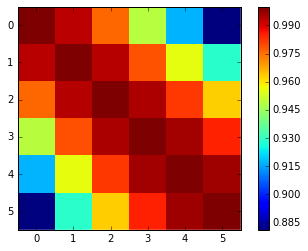

In [147]:
plt.imshow(np.corrcoef(models), interpolation='none')
plt.colorbar()